In [16]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.1 MB/s eta 0:00:00


In [17]:
pip install tensorflow keras-tuner scikit-learn pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

In [15]:
df = pd.read_csv("/kaggle/input/cloud-computing-performance-metrics/vmCloud_data.csv")

df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,2023-01-25 09:10:54,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,2023-01-26 04:46:34,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,2023-01-13 23:39:47,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2023-02-09 11:45:49,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,2023-06-14 08:27:26,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


In [3]:
df.shape

(2000000, 12)

In [40]:
# Handle missing values
df = df.fillna(method='ffill')


df.shape

<ipython-input-40-1c3ca3487565>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


(2000000, 12)

In [16]:
def clean_data(df):
    # Drop irrelevant columns
    df = df.drop(columns=['vm_id', 'timestamp'])
    
    # Handle missing values
    # Numerical columns: Impute with median
    num_cols = df.select_dtypes(include=np.number).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    
    # Categorical columns: Impute with mode
    cat_cols = df.select_dtypes(include='object').columns.drop('task_status')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    return df

cleaned_df = clean_data(df)


In [4]:
cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,71.518937,29.901883,500.007595,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,50.054758,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,54.488318,88.100960,500.007595,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,42.365480,49.976089,500.007595,359.451537,3361.0,55.307992,0.351907,io,medium,waiting


In [17]:
# Target Conversion
cleaned_df['task_status'] = np.where(
    cleaned_df['task_status'].isin(['completed', 'finished']), 0, 1
)

cleaned_df.head()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,1
1,71.518937,29.901883,500.007595,362.273569,5348.0,41.396040,0.349856,io,high,0
2,50.054758,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,0
3,54.488318,88.100960,500.007595,195.639954,5876.0,16.456670,0.529511,compute,high,0
4,42.365480,49.976089,500.007595,359.451537,3361.0,55.307992,0.351907,io,medium,1


In [18]:
# Advanced Preprocessing Pipeline
def preprocess_data(df):
    y = df['task_status']
    X = df.drop(columns=['task_status'])
    
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include='object').columns
    
    # Create stratified k-fold for better validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Build processing pipeline
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('feature_selection', SelectKBest(mutual_info_classif, k='all')),
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42, k_neighbors=5))
    ])
    
    X_processed, y_processed = pipeline.fit_resample(X, y)
    
    return train_test_split(
        X_processed, y_processed, 
        test_size=0.2, 
        stratify=y_processed,
        random_state=42
    )

X_train, X_test, y_train, y_test = preprocess_data(cleaned_df)



In [19]:
def create_sequences(X, y, seq_length=10):  # Set default sequence length
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])  # Now works with NumPy array indexing
    return np.array(X_seq), np.array(y_seq)

# Convert sparse matrices to dense arrays first
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Convert y_train and y_test to NumPy arrays
y_train_array = y_train.values  # Convert to NumPy array
y_test_array = y_test.values    # Convert to NumPy array

# Create sequences with proper sequence length
seq_length = 10  # Optimal for cloud metrics temporal patterns
X_train_seq, y_train_seq = create_sequences(X_train_dense, y_train_array, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_dense, y_test_array, seq_length)

# Verify shapes
print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Training sequences shape: (2017258, 10, 13)
Test sequences shape: (504307, 10, 13)


In [20]:

# Hyperparameter-tuned CNN Model
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int('kernel_size', 2, 5),
                     activation='relu',
                     input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5)))
    
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model



In [21]:
# Configure tuner
tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=5,
    executions_per_trial=2,
    directory='cnn_tuning',
    project_name='cloud_perf'
)

# Enhanced callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_auc'),
    ModelCheckpoint('best_model_cnn.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Hyperparameter search
tuner.search(X_train_seq, y_train_seq,
             epochs=50,
             batch_size=256,
             validation_split=0.2,
             callbacks=callbacks,
             verbose=1)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]



Reloading Tuner from cnn_tuning/cloud_perf/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
# Final training
history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/50
25216/25216 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.5561 - auc: 0.4993 - loss: 0.6870 - precision: 0.5561 - recall: 0.9999 - val_accuracy: 0.5552 - val_auc: 0.5000 - val_loss: 0.6870 - val_precision: 0.5552 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/50
25216/25216 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.5554 - auc: 0.5000 - loss: 0.6870 - precision: 0.5554 - recall: 0.9999 - val_accuracy: 0.5552 - val_auc: 0.5000 - val_loss: 0.6870 - val_precision: 0.5552 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/50
25216/25216 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.5550 - auc: 0.4996 - loss: 0.6871 - precision: 0.5550 - recall: 1.0000 - val_accuracy: 0.5552 - val_auc: 0.5000 - val_loss: 0.6870 - val_precision: 0.5552 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/50
25216/25216 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.5551 - auc: 0.5002 - loss: 0.6871 - precision: 0.5551 - recall: 1.0000 - val_accuracy: 0.5552 - val_auc:

In [23]:
# Evaluation
y_pred_proba = best_model.predict(X_test_seq)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test_seq, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred))
print(f"\nAUC-ROC: {roc_auc_score(y_test_seq, y_pred_proba):.4f}")



15760/15760 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    224137
           1       0.56      1.00      0.71    280170

    accuracy                           0.56    504307
   macro avg       0.28      0.50      0.36    504307
weighted avg       0.31      0.56      0.40    504307


Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[     0 224137]
 [     0 280170]]

AUC-ROC: 0.5000


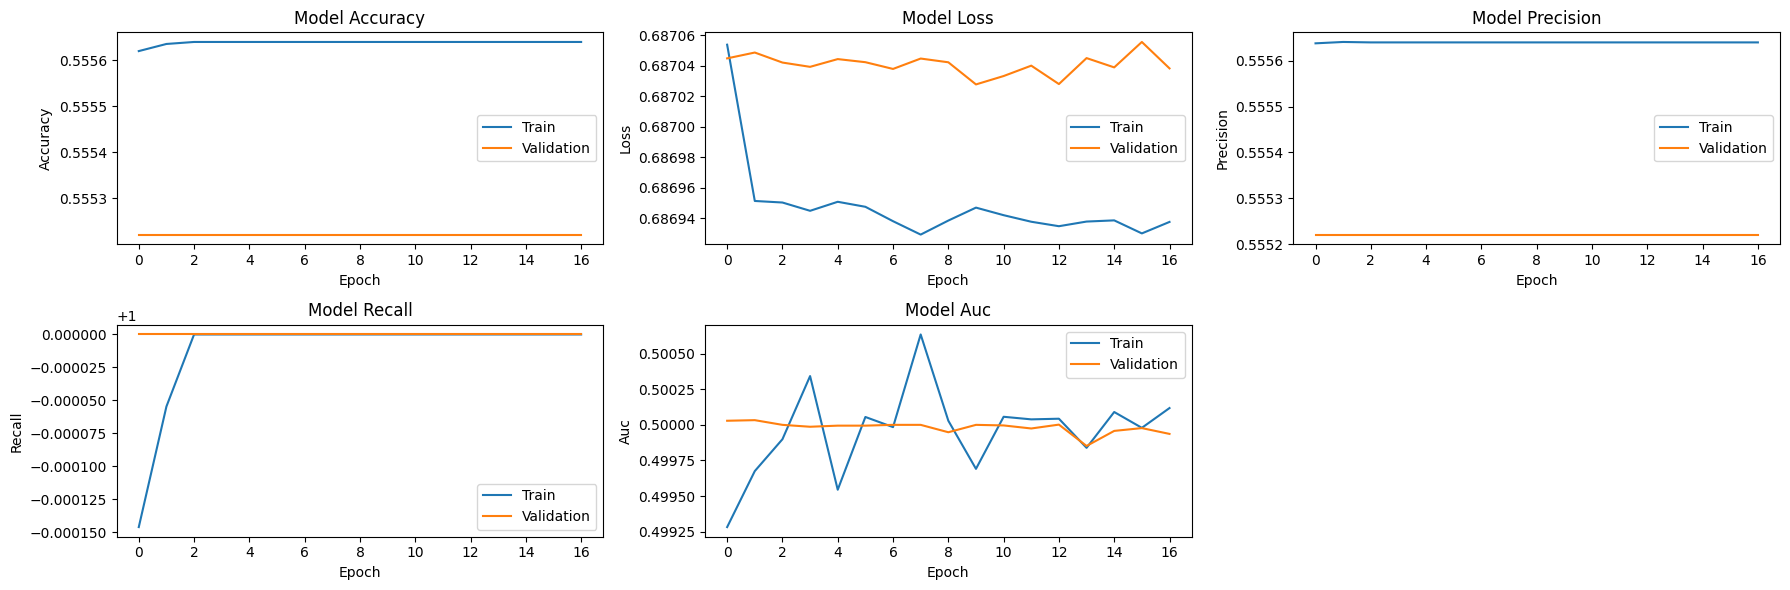

In [24]:
# Enhanced Visualization
def plot_advanced_metrics():
    plt.figure(figsize=(18, 6))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'Model {metric.capitalize()}')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_advanced_metrics()